# Matched Filtering for Event Template Detection

## Overview
This script implements a matched filtering technique to detect seismic events by comparing extracted templates from various stations against continuous seismic data. The goal is to identify strong correlations between the templates and segments of the continuous data.

## Methodology
1. **Data Preparation**:
   - The script first reads the continuous waveform data and the previously extracted templates.
   - A band-pass filter is applied to the continuous data; frequency range is 1-200 Hz.

2. **Template Matching**:
   - The continuous data is divided into segments that match the length of the templates.
   - For each segment, the script performs cross-correlation with each template to find the maximum correlation value.
   - The start time of the segment is calculated to provide precise temporal information regarding the detected events.

3. **Thresholding**:
   - If the maximum correlation value exceeds a predefined threshold, the results (start time, station name, and correlation value) are stored in a dictionary.

4. **Output**:
   - The results are printed to the console, and they are saved in a folder named **"DetectedEvents"**. Each detected event is saved as a NumPy file, and detailed results are stored in a JSON file.
   - Additionally, the script plots examples of the detected events to visually assess their characteristics.
    - A separate JSON file containing the detected times is also created.


## Key Parameters
- **TEMPLATE_DURATION**: Duration of each template in seconds (default: 4 seconds).
- **SAMPLE_RATE**: The sampling rate of the continuous data (default: 500 Hz).
- **CORRELATION_THRESHOLD**: Threshold value for maximum correlation to filter significant results (default: 0.5).

## Dependencies
This script requires the following Python libraries:
- `obspy` for seismic data processing.
- `numpy` for numerical operations.
- `glob` and `os` for file operations.
- `json` for data serialization.
- `matplotlib` for plotting.

Make sure these libraries are installed in your Python environment before running the script.


# Matched Filtering Example for One Station

In [3]:
import obspy
import numpy as np
import glob
import os
import json
from Xcorr import *

# Create an output directory for results if it doesn't exist
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Constants
TEMPLATE_DURATION = 4               # Duration of each template in seconds
SAMPLE_RATE = 500                   # Sample rate of the continuous data (assuming 500 Hz)
TEMPLATE_LENGTH = TEMPLATE_DURATION * SAMPLE_RATE + 1  # Number of samples per template
CORRELATION_THRESHOLD = 0.4         # Define a threshold for maximum correlation
WINDOW_STEP = 1                     # Step size for the moving window in seconds


#Saving Detected Events: When a detected event has a maximum correlation above the threshold
detected_events_dir = 'DetectedEvents'
os.makedirs(detected_events_dir, exist_ok=True)

# Read continuous data paths and templates' folder
data_paths = glob.glob('data/*.mseed')
template_paths = glob.glob('database/*.npy')  # Adjust this path pattern based on your template structure

# Make sure we have continuous data files
if not data_paths:
    raise FileNotFoundError("No continuous data files found in the specified path.")

# Test with the first continuous data file
first_data_file = data_paths[0]  # Take the first continuous data file
print(f"Testing with Continuous Data File: {first_data_file}")

# Read the continuous data stream
st = obspy.read(first_data_file)

# Apply a band-pass filter to the continuous data (1-200 Hz)
st.filter('bandpass', freqmin=1, freqmax=200, corners=4, zerophase=False)

# Get the station name from the first trace
station_name = st[0].stats.station
print(f"Using Station: {station_name}")

# Filter template paths to get only those that match the first station's templates
specific_templates = [tp for tp in template_paths if station_name in tp]

# Ensure we have corresponding templates for the first station
if not specific_templates:
    raise FileNotFoundError(f"No template files found for station: {station_name}")

# Dictionary to store results
results_dict = {}

# Calculate the number of segments with a moving window of 1 second
num_segments = int(len(st[0].data) / SAMPLE_RATE) - TEMPLATE_DURATION + 1

# Iterate through each segment of the continuous data with a moving window
for i in range(num_segments):
    # Extract a segment of continuous data with the corresponding template length
    start_index = i * SAMPLE_RATE  # Convert seconds to sample index
    segment = st[0].data[start_index:start_index + TEMPLATE_LENGTH]

    # Normalize the segment to have a maximum absolute value of 1
    if np.max(np.abs(segment)) == 0:  # Check to avoid division by zero
        continue
    segment /= np.max(np.abs(segment))

    # Process each template file corresponding to the first station
    for template_file in specific_templates:

        results = []
        # Load the extracted template
        template_data = np.load(template_file)

        # For each template, compute the matched filter
        for template in template_data:
            # Ensure the template has the appropriate size
            if len(template) != TEMPLATE_LENGTH:
                print(f"Template size mismatch for {os.path.basename(template_file)}. Skipping.")
                continue

            # Cross-correlate the normalized segment with the template
            results.append(np.abs(Xcorr(segment, template)))

        # Find the maximum correlation value and its index
        max_corr_index = np.argmax(results)
        max_corr_value = results[max_corr_index]

        # Calculate the start time based on the segment index
        start_time = st[0].stats.starttime + (i * WINDOW_STEP)

        # Check if the maximum correlation exceeds the threshold
        if max_corr_value > CORRELATION_THRESHOLD:
            # Store the information in the results dictionary
            results_dict[start_time.isoformat()] = {
                "station": station_name,
                "max_correlation": max_corr_value,
                "segment_index": i
            }
            
            # Format the start time in a string format suitable for filenames
            start_time_str = start_time.strftime("%Y%m%d_%H%M%S")

            # Save detected event segment as a NumPy file with start time in the filename
            detected_event_filename = os.path.join(detected_events_dir, f"detected_event_{station_name}_{start_time_str}.npy")
            np.save(detected_event_filename, segment)

            # Print the results
            print(f"Template from {os.path.basename(template_file)} at segment {i}:")
            print(f"  Max Correlation: {max_corr_value:.4f} for segment starting at {start_time.isoformat()}")



# Optionally save the results dictionary to a file for further analysis
with open(os.path.join(output_dir, 'matched_filter_results.json'), 'w') as f:
    json.dump(results_dict, f, indent=4)
    
# Print the number of detected events
print(f"\nNumber of detected events: {len(results_dict)}")

Testing with Continuous Data File: data/1177.5B.mseed
Using Station: 1177
Template from 1177.npy at segment 17:
  Max Correlation: 0.4357 for segment starting at 2016-11-01T00:00:17
Template from 1177.npy at segment 19:
  Max Correlation: 0.4756 for segment starting at 2016-11-01T00:00:19
Template from 1177.npy at segment 24:
  Max Correlation: 0.5376 for segment starting at 2016-11-01T00:00:24
Template from 1177.npy at segment 53:
  Max Correlation: 0.4045 for segment starting at 2016-11-01T00:00:53
Template from 1177.npy at segment 334:
  Max Correlation: 0.4286 for segment starting at 2016-11-01T00:05:34
Template from 1177.npy at segment 385:
  Max Correlation: 0.4538 for segment starting at 2016-11-01T00:06:25
Template from 1177.npy at segment 388:
  Max Correlation: 0.4771 for segment starting at 2016-11-01T00:06:28
Template from 1177.npy at segment 422:
  Max Correlation: 0.4477 for segment starting at 2016-11-01T00:07:02
Template from 1177.npy at segment 433:
  Max Correlation: 

Template from 1177.npy at segment 3044:
  Max Correlation: 0.4323 for segment starting at 2016-11-01T00:50:44
Template from 1177.npy at segment 3063:
  Max Correlation: 0.4347 for segment starting at 2016-11-01T00:51:03
Template from 1177.npy at segment 3115:
  Max Correlation: 0.4501 for segment starting at 2016-11-01T00:51:55
Template from 1177.npy at segment 3127:
  Max Correlation: 0.4254 for segment starting at 2016-11-01T00:52:07
Template from 1177.npy at segment 3330:
  Max Correlation: 0.5209 for segment starting at 2016-11-01T00:55:30
Template from 1177.npy at segment 3458:
  Max Correlation: 0.4452 for segment starting at 2016-11-01T00:57:38
Template from 1177.npy at segment 3473:
  Max Correlation: 0.4189 for segment starting at 2016-11-01T00:57:53
Template from 1177.npy at segment 3485:
  Max Correlation: 0.4172 for segment starting at 2016-11-01T00:58:05
Template from 1177.npy at segment 3578:
  Max Correlation: 0.5179 for segment starting at 2016-11-01T00:59:38
Template f

Template from 1177.npy at segment 6381:
  Max Correlation: 0.4041 for segment starting at 2016-11-01T01:46:21
Template from 1177.npy at segment 6406:
  Max Correlation: 0.4581 for segment starting at 2016-11-01T01:46:46
Template from 1177.npy at segment 6466:
  Max Correlation: 0.4150 for segment starting at 2016-11-01T01:47:46
Template from 1177.npy at segment 6492:
  Max Correlation: 0.4029 for segment starting at 2016-11-01T01:48:12
Template from 1177.npy at segment 6531:
  Max Correlation: 0.4075 for segment starting at 2016-11-01T01:48:51
Template from 1177.npy at segment 6536:
  Max Correlation: 0.9834 for segment starting at 2016-11-01T01:48:56
Template from 1177.npy at segment 6588:
  Max Correlation: 0.4250 for segment starting at 2016-11-01T01:49:48
Template from 1177.npy at segment 6603:
  Max Correlation: 0.4327 for segment starting at 2016-11-01T01:50:03
Template from 1177.npy at segment 6622:
  Max Correlation: 0.4094 for segment starting at 2016-11-01T01:50:22
Template f

Template from 1177.npy at segment 10876:
  Max Correlation: 0.9226 for segment starting at 2016-11-01T03:01:16
Template from 1177.npy at segment 10886:
  Max Correlation: 0.4250 for segment starting at 2016-11-01T03:01:26
Template from 1177.npy at segment 10976:
  Max Correlation: 0.4307 for segment starting at 2016-11-01T03:02:56
Template from 1177.npy at segment 11050:
  Max Correlation: 0.4026 for segment starting at 2016-11-01T03:04:10
Template from 1177.npy at segment 11058:
  Max Correlation: 0.4199 for segment starting at 2016-11-01T03:04:18
Template from 1177.npy at segment 11129:
  Max Correlation: 0.4041 for segment starting at 2016-11-01T03:05:29
Template from 1177.npy at segment 11164:
  Max Correlation: 0.4248 for segment starting at 2016-11-01T03:06:04
Template from 1177.npy at segment 11226:
  Max Correlation: 0.4390 for segment starting at 2016-11-01T03:07:06
Template from 1177.npy at segment 11254:
  Max Correlation: 0.4010 for segment starting at 2016-11-01T03:07:34
T

Template from 1177.npy at segment 14342:
  Max Correlation: 0.4020 for segment starting at 2016-11-01T03:59:02
Template from 1177.npy at segment 14460:
  Max Correlation: 0.4241 for segment starting at 2016-11-01T04:01:00
Template from 1177.npy at segment 14463:
  Max Correlation: 0.4773 for segment starting at 2016-11-01T04:01:03
Template from 1177.npy at segment 14475:
  Max Correlation: 0.4043 for segment starting at 2016-11-01T04:01:15
Template from 1177.npy at segment 14488:
  Max Correlation: 0.4385 for segment starting at 2016-11-01T04:01:28
Template from 1177.npy at segment 14663:
  Max Correlation: 0.4549 for segment starting at 2016-11-01T04:04:23
Template from 1177.npy at segment 14665:
  Max Correlation: 0.4071 for segment starting at 2016-11-01T04:04:25
Template from 1177.npy at segment 14719:
  Max Correlation: 0.4023 for segment starting at 2016-11-01T04:05:19
Template from 1177.npy at segment 14781:
  Max Correlation: 0.4239 for segment starting at 2016-11-01T04:06:21
T

Template from 1177.npy at segment 19308:
  Max Correlation: 0.4003 for segment starting at 2016-11-01T05:21:48
Template from 1177.npy at segment 19360:
  Max Correlation: 0.4040 for segment starting at 2016-11-01T05:22:40
Template from 1177.npy at segment 19499:
  Max Correlation: 0.4687 for segment starting at 2016-11-01T05:24:59
Template from 1177.npy at segment 19535:
  Max Correlation: 0.4022 for segment starting at 2016-11-01T05:25:35
Template from 1177.npy at segment 19555:
  Max Correlation: 0.4047 for segment starting at 2016-11-01T05:25:55
Template from 1177.npy at segment 19648:
  Max Correlation: 0.4323 for segment starting at 2016-11-01T05:27:28
Template from 1177.npy at segment 19653:
  Max Correlation: 0.6686 for segment starting at 2016-11-01T05:27:33
Template from 1177.npy at segment 19699:
  Max Correlation: 0.4010 for segment starting at 2016-11-01T05:28:19
Template from 1177.npy at segment 19833:
  Max Correlation: 0.4474 for segment starting at 2016-11-01T05:30:33
T

Template from 1177.npy at segment 24559:
  Max Correlation: 0.4194 for segment starting at 2016-11-01T06:49:19
Template from 1177.npy at segment 24626:
  Max Correlation: 0.4785 for segment starting at 2016-11-01T06:50:26
Template from 1177.npy at segment 24703:
  Max Correlation: 0.5719 for segment starting at 2016-11-01T06:51:43
Template from 1177.npy at segment 24765:
  Max Correlation: 0.4307 for segment starting at 2016-11-01T06:52:45
Template from 1177.npy at segment 24766:
  Max Correlation: 0.4502 for segment starting at 2016-11-01T06:52:46
Template from 1177.npy at segment 24812:
  Max Correlation: 0.4128 for segment starting at 2016-11-01T06:53:32
Template from 1177.npy at segment 24888:
  Max Correlation: 0.4376 for segment starting at 2016-11-01T06:54:48
Template from 1177.npy at segment 24900:
  Max Correlation: 0.4113 for segment starting at 2016-11-01T06:55:00
Template from 1177.npy at segment 24984:
  Max Correlation: 0.4033 for segment starting at 2016-11-01T06:56:24
T

Template from 1177.npy at segment 28950:
  Max Correlation: 0.4335 for segment starting at 2016-11-01T08:02:30
Template from 1177.npy at segment 28999:
  Max Correlation: 0.4037 for segment starting at 2016-11-01T08:03:19
Template from 1177.npy at segment 29001:
  Max Correlation: 0.5006 for segment starting at 2016-11-01T08:03:21
Template from 1177.npy at segment 29035:
  Max Correlation: 0.4014 for segment starting at 2016-11-01T08:03:55
Template from 1177.npy at segment 29058:
  Max Correlation: 0.4736 for segment starting at 2016-11-01T08:04:18
Template from 1177.npy at segment 29100:
  Max Correlation: 0.4329 for segment starting at 2016-11-01T08:05:00
Template from 1177.npy at segment 29117:
  Max Correlation: 0.4510 for segment starting at 2016-11-01T08:05:17
Template from 1177.npy at segment 29183:
  Max Correlation: 0.4326 for segment starting at 2016-11-01T08:06:23
Template from 1177.npy at segment 29321:
  Max Correlation: 0.4256 for segment starting at 2016-11-01T08:08:41
T

Template from 1177.npy at segment 31967:
  Max Correlation: 0.4246 for segment starting at 2016-11-01T08:52:47
Template from 1177.npy at segment 31976:
  Max Correlation: 0.4020 for segment starting at 2016-11-01T08:52:56
Template from 1177.npy at segment 32074:
  Max Correlation: 0.4751 for segment starting at 2016-11-01T08:54:34
Template from 1177.npy at segment 32081:
  Max Correlation: 0.4073 for segment starting at 2016-11-01T08:54:41
Template from 1177.npy at segment 32153:
  Max Correlation: 0.7087 for segment starting at 2016-11-01T08:55:53
Template from 1177.npy at segment 32222:
  Max Correlation: 0.4244 for segment starting at 2016-11-01T08:57:02
Template from 1177.npy at segment 32267:
  Max Correlation: 0.4566 for segment starting at 2016-11-01T08:57:47
Template from 1177.npy at segment 32339:
  Max Correlation: 0.4116 for segment starting at 2016-11-01T08:58:59
Template from 1177.npy at segment 32449:
  Max Correlation: 0.4247 for segment starting at 2016-11-01T09:00:49
T

Template from 1177.npy at segment 35962:
  Max Correlation: 0.4188 for segment starting at 2016-11-01T09:59:22
Template from 1177.npy at segment 35968:
  Max Correlation: 0.4281 for segment starting at 2016-11-01T09:59:28
Template from 1177.npy at segment 35986:
  Max Correlation: 0.4320 for segment starting at 2016-11-01T09:59:46
Template from 1177.npy at segment 36007:
  Max Correlation: 0.4253 for segment starting at 2016-11-01T10:00:07
Template from 1177.npy at segment 36131:
  Max Correlation: 0.4071 for segment starting at 2016-11-01T10:02:11
Template from 1177.npy at segment 36441:
  Max Correlation: 0.4111 for segment starting at 2016-11-01T10:07:21
Template from 1177.npy at segment 36765:
  Max Correlation: 0.4204 for segment starting at 2016-11-01T10:12:45
Template from 1177.npy at segment 37127:
  Max Correlation: 0.4167 for segment starting at 2016-11-01T10:18:47
Template from 1177.npy at segment 37135:
  Max Correlation: 0.4051 for segment starting at 2016-11-01T10:18:55
T

Template from 1177.npy at segment 41429:
  Max Correlation: 0.4453 for segment starting at 2016-11-01T11:30:29
Template from 1177.npy at segment 41459:
  Max Correlation: 0.4087 for segment starting at 2016-11-01T11:30:59
Template from 1177.npy at segment 41517:
  Max Correlation: 0.4047 for segment starting at 2016-11-01T11:31:57
Template from 1177.npy at segment 41606:
  Max Correlation: 0.4113 for segment starting at 2016-11-01T11:33:26
Template from 1177.npy at segment 41616:
  Max Correlation: 0.4244 for segment starting at 2016-11-01T11:33:36
Template from 1177.npy at segment 41643:
  Max Correlation: 0.4332 for segment starting at 2016-11-01T11:34:03
Template from 1177.npy at segment 41725:
  Max Correlation: 0.4011 for segment starting at 2016-11-01T11:35:25
Template from 1177.npy at segment 41732:
  Max Correlation: 0.4221 for segment starting at 2016-11-01T11:35:32
Template from 1177.npy at segment 41741:
  Max Correlation: 0.4140 for segment starting at 2016-11-01T11:35:41
T

Template from 1177.npy at segment 44672:
  Max Correlation: 0.4019 for segment starting at 2016-11-01T12:24:32
Template from 1177.npy at segment 44703:
  Max Correlation: 0.4250 for segment starting at 2016-11-01T12:25:03
Template from 1177.npy at segment 44762:
  Max Correlation: 0.4150 for segment starting at 2016-11-01T12:26:02
Template from 1177.npy at segment 44784:
  Max Correlation: 0.4835 for segment starting at 2016-11-01T12:26:24
Template from 1177.npy at segment 44799:
  Max Correlation: 0.4210 for segment starting at 2016-11-01T12:26:39
Template from 1177.npy at segment 44939:
  Max Correlation: 0.4028 for segment starting at 2016-11-01T12:28:59
Template from 1177.npy at segment 44993:
  Max Correlation: 0.4126 for segment starting at 2016-11-01T12:29:53
Template from 1177.npy at segment 45042:
  Max Correlation: 0.4206 for segment starting at 2016-11-01T12:30:42
Template from 1177.npy at segment 45048:
  Max Correlation: 0.4357 for segment starting at 2016-11-01T12:30:48
T

Template from 1177.npy at segment 48240:
  Max Correlation: 0.4967 for segment starting at 2016-11-01T13:24:00
Template from 1177.npy at segment 48295:
  Max Correlation: 0.4071 for segment starting at 2016-11-01T13:24:55
Template from 1177.npy at segment 48303:
  Max Correlation: 0.4141 for segment starting at 2016-11-01T13:25:03
Template from 1177.npy at segment 48337:
  Max Correlation: 0.4124 for segment starting at 2016-11-01T13:25:37
Template from 1177.npy at segment 48340:
  Max Correlation: 0.4026 for segment starting at 2016-11-01T13:25:40
Template from 1177.npy at segment 48391:
  Max Correlation: 0.4478 for segment starting at 2016-11-01T13:26:31
Template from 1177.npy at segment 48406:
  Max Correlation: 0.4308 for segment starting at 2016-11-01T13:26:46
Template from 1177.npy at segment 48530:
  Max Correlation: 0.4797 for segment starting at 2016-11-01T13:28:50
Template from 1177.npy at segment 48670:
  Max Correlation: 0.4020 for segment starting at 2016-11-01T13:31:10
T

Template from 1177.npy at segment 52568:
  Max Correlation: 0.5006 for segment starting at 2016-11-01T14:36:08
Template from 1177.npy at segment 52580:
  Max Correlation: 0.4360 for segment starting at 2016-11-01T14:36:20
Template from 1177.npy at segment 52646:
  Max Correlation: 0.5055 for segment starting at 2016-11-01T14:37:26
Template from 1177.npy at segment 52847:
  Max Correlation: 0.4001 for segment starting at 2016-11-01T14:40:47
Template from 1177.npy at segment 52858:
  Max Correlation: 0.4125 for segment starting at 2016-11-01T14:40:58
Template from 1177.npy at segment 52864:
  Max Correlation: 0.4474 for segment starting at 2016-11-01T14:41:04
Template from 1177.npy at segment 52880:
  Max Correlation: 0.4062 for segment starting at 2016-11-01T14:41:20
Template from 1177.npy at segment 53099:
  Max Correlation: 0.5503 for segment starting at 2016-11-01T14:44:59
Template from 1177.npy at segment 53100:
  Max Correlation: 0.4435 for segment starting at 2016-11-01T14:45:00
T

Template from 1177.npy at segment 56805:
  Max Correlation: 0.4185 for segment starting at 2016-11-01T15:46:45
Template from 1177.npy at segment 57010:
  Max Correlation: 0.4736 for segment starting at 2016-11-01T15:50:10
Template from 1177.npy at segment 57086:
  Max Correlation: 0.4390 for segment starting at 2016-11-01T15:51:26
Template from 1177.npy at segment 57167:
  Max Correlation: 0.4545 for segment starting at 2016-11-01T15:52:47
Template from 1177.npy at segment 57287:
  Max Correlation: 0.4604 for segment starting at 2016-11-01T15:54:47
Template from 1177.npy at segment 57318:
  Max Correlation: 0.4117 for segment starting at 2016-11-01T15:55:18
Template from 1177.npy at segment 57350:
  Max Correlation: 0.4018 for segment starting at 2016-11-01T15:55:50
Template from 1177.npy at segment 57365:
  Max Correlation: 0.4039 for segment starting at 2016-11-01T15:56:05
Template from 1177.npy at segment 57370:
  Max Correlation: 0.4003 for segment starting at 2016-11-01T15:56:10
T

Template from 1177.npy at segment 61737:
  Max Correlation: 0.4086 for segment starting at 2016-11-01T17:08:57
Template from 1177.npy at segment 61804:
  Max Correlation: 0.9222 for segment starting at 2016-11-01T17:10:04
Template from 1177.npy at segment 62373:
  Max Correlation: 0.4063 for segment starting at 2016-11-01T17:19:33
Template from 1177.npy at segment 62715:
  Max Correlation: 0.4697 for segment starting at 2016-11-01T17:25:15
Template from 1177.npy at segment 63092:
  Max Correlation: 0.4478 for segment starting at 2016-11-01T17:31:32
Template from 1177.npy at segment 63098:
  Max Correlation: 0.4022 for segment starting at 2016-11-01T17:31:38
Template from 1177.npy at segment 63099:
  Max Correlation: 0.4171 for segment starting at 2016-11-01T17:31:39
Template from 1177.npy at segment 63264:
  Max Correlation: 0.4230 for segment starting at 2016-11-01T17:34:24
Template from 1177.npy at segment 63311:
  Max Correlation: 0.4346 for segment starting at 2016-11-01T17:35:11
T

Template from 1177.npy at segment 69355:
  Max Correlation: 0.4242 for segment starting at 2016-11-01T19:15:55
Template from 1177.npy at segment 69765:
  Max Correlation: 0.4097 for segment starting at 2016-11-01T19:22:45
Template from 1177.npy at segment 69903:
  Max Correlation: 0.4100 for segment starting at 2016-11-01T19:25:03
Template from 1177.npy at segment 69924:
  Max Correlation: 0.4026 for segment starting at 2016-11-01T19:25:24
Template from 1177.npy at segment 69927:
  Max Correlation: 0.4417 for segment starting at 2016-11-01T19:25:27
Template from 1177.npy at segment 70056:
  Max Correlation: 0.4293 for segment starting at 2016-11-01T19:27:36
Template from 1177.npy at segment 70463:
  Max Correlation: 0.4292 for segment starting at 2016-11-01T19:34:23
Template from 1177.npy at segment 70506:
  Max Correlation: 0.4348 for segment starting at 2016-11-01T19:35:06
Template from 1177.npy at segment 70525:
  Max Correlation: 0.4343 for segment starting at 2016-11-01T19:35:25
T

Template from 1177.npy at segment 77647:
  Max Correlation: 0.4066 for segment starting at 2016-11-01T21:34:07
Template from 1177.npy at segment 77657:
  Max Correlation: 0.4374 for segment starting at 2016-11-01T21:34:17
Template from 1177.npy at segment 77739:
  Max Correlation: 0.4149 for segment starting at 2016-11-01T21:35:39
Template from 1177.npy at segment 77812:
  Max Correlation: 0.4017 for segment starting at 2016-11-01T21:36:52
Template from 1177.npy at segment 77844:
  Max Correlation: 0.4303 for segment starting at 2016-11-01T21:37:24
Template from 1177.npy at segment 78076:
  Max Correlation: 0.4006 for segment starting at 2016-11-01T21:41:16
Template from 1177.npy at segment 78154:
  Max Correlation: 0.4138 for segment starting at 2016-11-01T21:42:34
Template from 1177.npy at segment 78228:
  Max Correlation: 0.5526 for segment starting at 2016-11-01T21:43:48
Template from 1177.npy at segment 78270:
  Max Correlation: 0.4329 for segment starting at 2016-11-01T21:44:30
T

Template from 1177.npy at segment 84958:
  Max Correlation: 0.4404 for segment starting at 2016-11-01T23:35:58
Template from 1177.npy at segment 84962:
  Max Correlation: 0.4299 for segment starting at 2016-11-01T23:36:02
Template from 1177.npy at segment 85120:
  Max Correlation: 0.4048 for segment starting at 2016-11-01T23:38:40
Template from 1177.npy at segment 85263:
  Max Correlation: 0.4112 for segment starting at 2016-11-01T23:41:03
Template from 1177.npy at segment 85343:
  Max Correlation: 0.4568 for segment starting at 2016-11-01T23:42:23
Template from 1177.npy at segment 85367:
  Max Correlation: 0.4990 for segment starting at 2016-11-01T23:42:47
Template from 1177.npy at segment 85440:
  Max Correlation: 0.4405 for segment starting at 2016-11-01T23:44:00
Template from 1177.npy at segment 85534:
  Max Correlation: 0.4276 for segment starting at 2016-11-01T23:45:34
Template from 1177.npy at segment 85582:
  Max Correlation: 0.4260 for segment starting at 2016-11-01T23:46:22
T

## Plotting Detected Events

This section of the script is designed to visualize the detected seismic events stored in the `DetectedEvents` folder. The goal is to extract and plot the segments of the detected events, including one second of data before each event's starting time.

### Overview:
- **Input**: The script loads `.npy` files containing the detected event data from the `DetectedEvents` directory.
- **Visualization**: It creates subplots for each detected event to show the waveform of the seismic signals over time.
- **Configuration**:
  - The plots are organized into a grid of subplots, allowing for up to 10 events to be displayed in one figure.
  - Each subplot includes the detected event's amplitude over time, and the x-axis is scaled to show the time window around the detected event.

### Usage:
- Make sure that the `DetectedEvents` folder contains the detected event files generated in the previous steps.
- You can adjust the number of samples plotted by modifying the variable `num_samples_to_plot`.
- The figure will be displayed to the user and will also be saved as a PNG file for future reference.

### Output:
Upon execution, this code will display the waveforms of the detected events, allowing users to visually assess the characteristics and amplitudes of each seismic event segment.


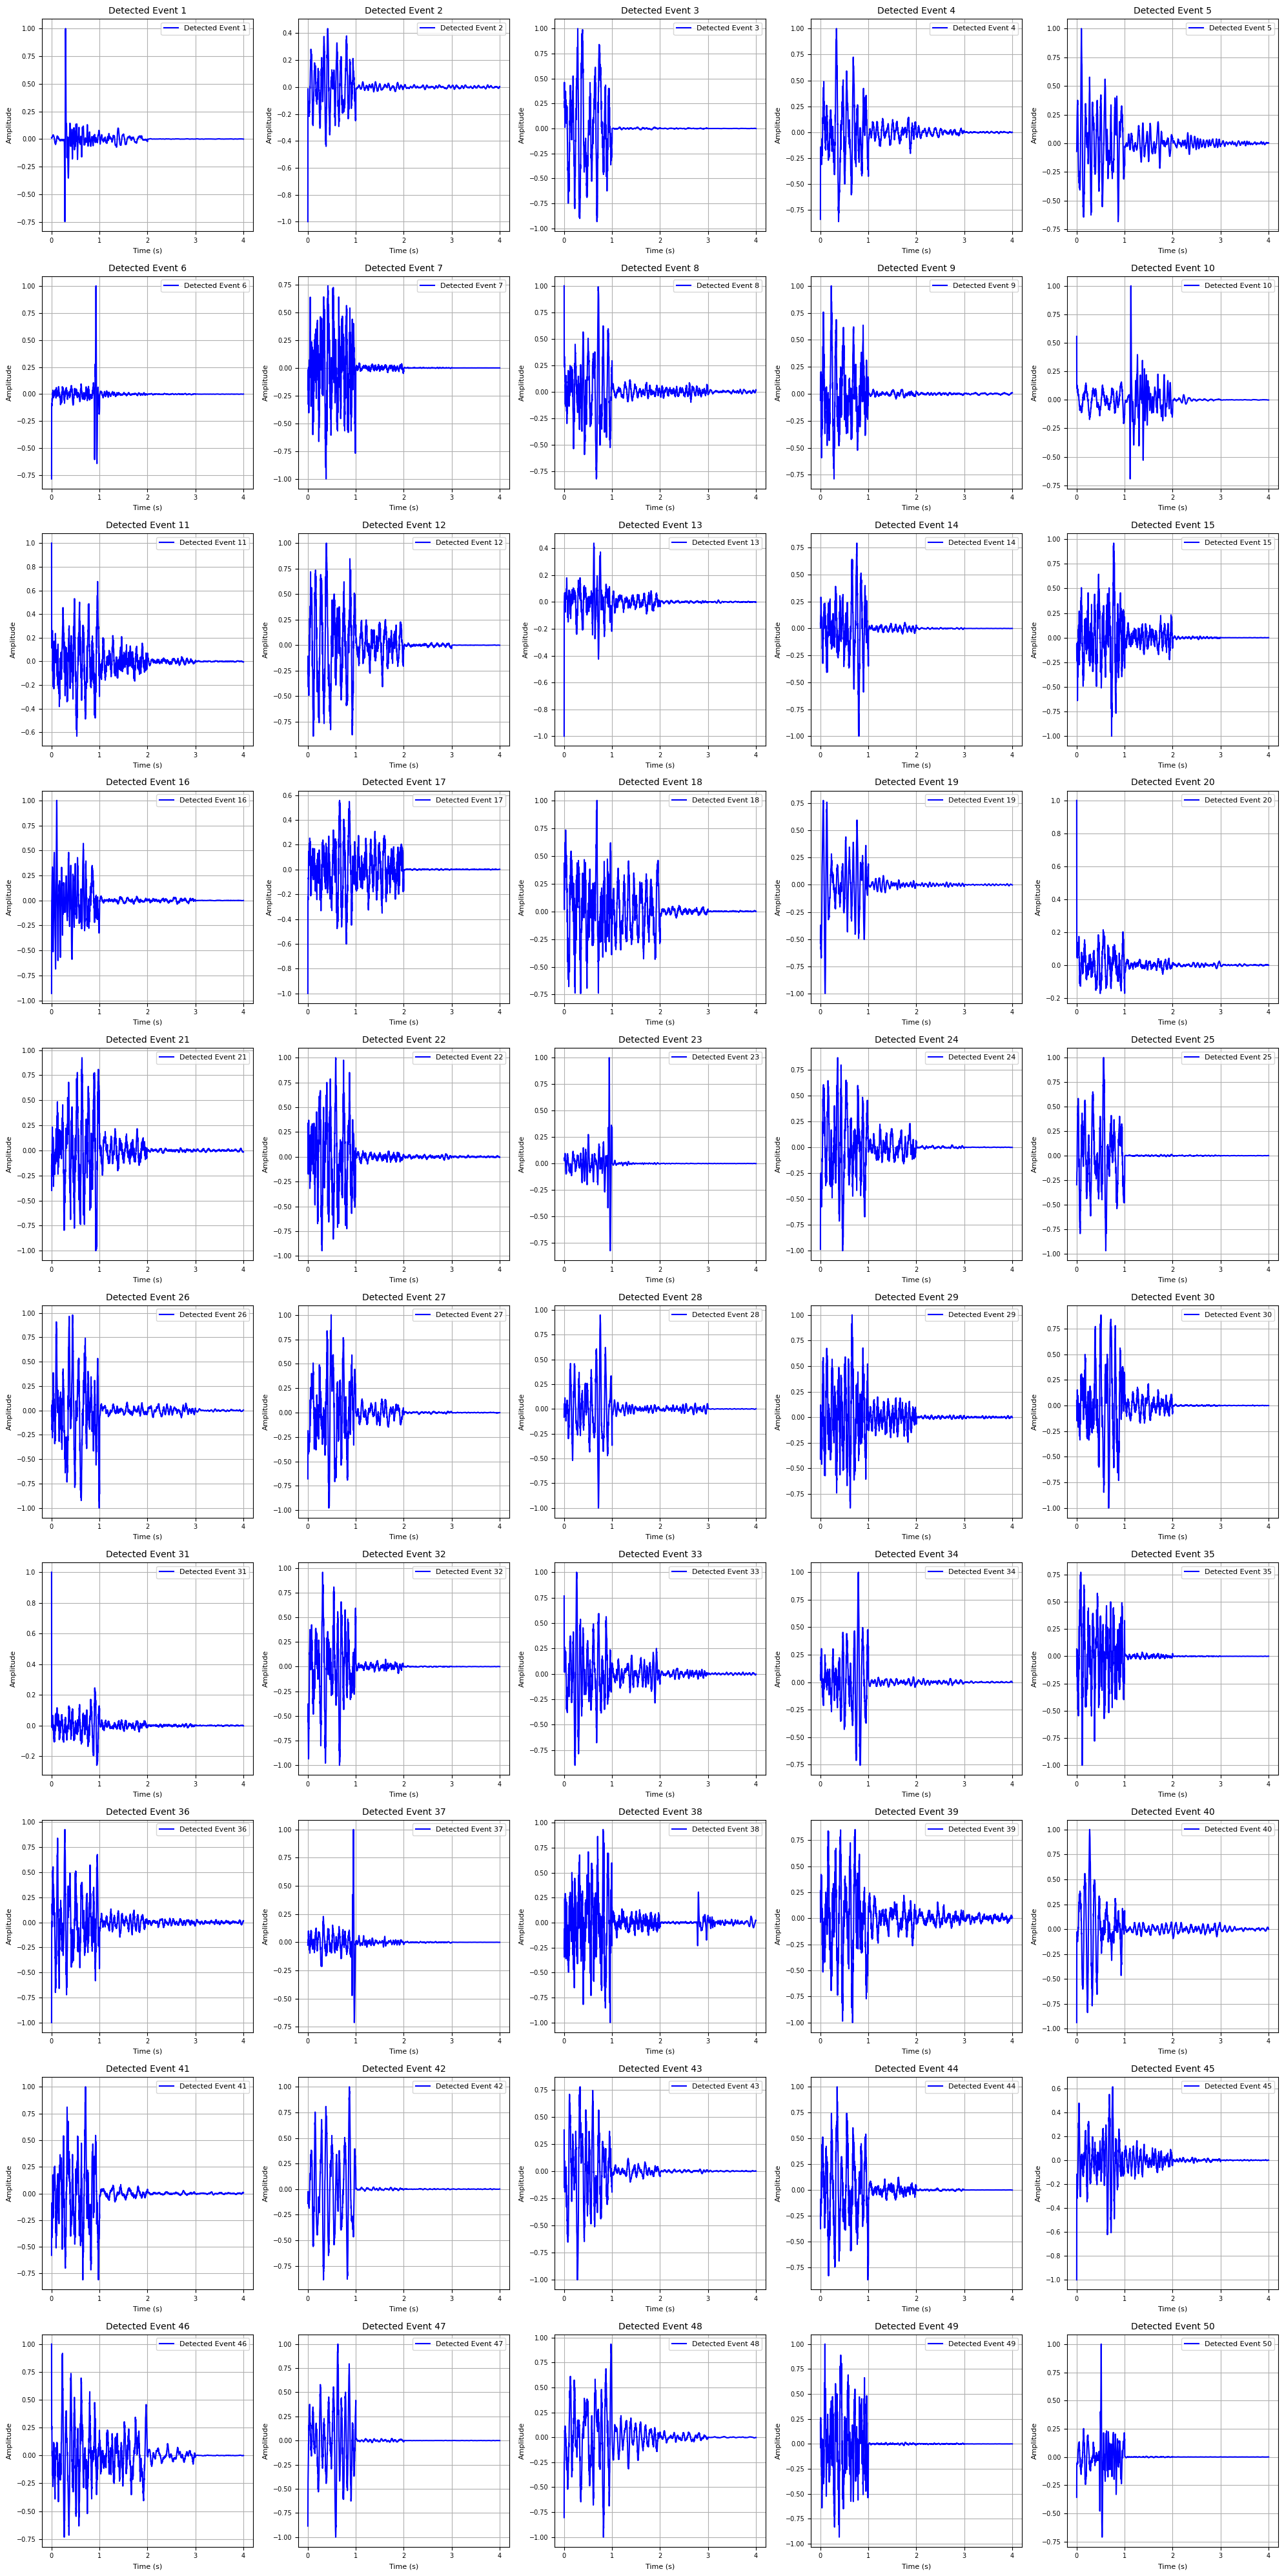

In [4]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

# Directory containing detected events
detected_events_dir = 'DetectedEvents'

# Load detected events (.npy files)
detected_events_files = glob.glob(f'{detected_events_dir}/*.npy')

# Select up to 50 samples to plot (or fewer if less available)
num_samples_to_plot = min(50, len(detected_events_files))

# Create a plot for the detected events
plt.figure(figsize=(20, 40))  # Adjust size for better visibility

# Sample rate (assuming 500 Hz)
sample_rate = 500

# Determine the grid size for subplots
num_rows = 10  # 10 rows
num_cols = 5   # 5 columns

for i in range(num_samples_to_plot):
    # Load the detected event
    event_data = np.load(detected_events_files[i])
    
    # Create a time axis for plotting (length of the event data)
    time_axis = np.linspace(0, len(event_data) / sample_rate, num=len(event_data))  # Time from 0 to duration

    # Plot the event data in a subplot
    plt.subplot(num_rows, num_cols, i + 1)  # 10 rows and 5 columns of subplots
    plt.plot(time_axis, event_data, label=f'Detected Event {i + 1}', color='b')
    plt.title(f'Detected Event {i + 1}', fontsize=10)
    plt.xlabel('Time (s)', fontsize=8)
    plt.ylabel('Amplitude', fontsize=8)
    plt.grid()
    plt.legend(fontsize=8)

    # Adjust ticks for smaller subplots
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
#plt.savefig('detected_events_plot.png')  # Save the figure as a PNG file
